[View in Colaboratory](https://colab.research.google.com/github/choudharykrish/ContentBlocker/blob/master/Blocker_(3).ipynb)

In [0]:
!kill -9 -1


# MOUNTING DRIVE




In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force

Enter verification code: ··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [4]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

#print 'Files in Drive:'
!ls drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

199d0f91-feb7-4657-a1c8-9f3b3512503d-large.jpeg  created.txt
5th Sem						 EYRC
6th Sem						 HackWithInfy
Advanced Java CPD				 HackWithInfy Travel Documents
Certifications Originals - Page 5.jpg		 Mom School Stuff
Certifications Originals.pdf			 P Guide.pdf
ChatBot						 Tuberculosis
Colab Notebooks					 ZS Data Science 
ContentBlocker


In [5]:
!pwd
!ls

/content
adc.json  drive  sample_data


# IMPORTING LIBRARIES' FILES

In [6]:
from google.colab import files
src = list(files.upload().values())[0]
open('vgg16.py','wb').write(src)
import vgg16

Saving vgg16.py to vgg16.py


Using TensorFlow backend.


In [7]:
from google.colab import files
src = list(files.upload().values())[0]
open('imagenet_utils.py','wb').write(src)
import imagenet_utils

Saving imagenet_utils.py to imagenet_utils.py


# CODE STARTS

In [8]:
import numpy as np
import os
import time
from vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input
from imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
PATH = os.getcwd()
print(PATH)
# Define data path
data_path = PATH + '/drive/ContentBlocker/Dataset'
print(data_path)
data_dir_list = os.listdir(data_path)

/content
/content/drive/ContentBlocker/Dataset


In [0]:

nb_train_samples = 2981
epochs = 20
nb_validation_samples = 298
batch_size = 50
resX = 224
resY = 224
num_classes = 3

In [13]:
for dataset in data_dir_list:
  print(dataset)

model_weights.h5
Test
Train


## Image Augmentation (Including Fine Tuning)

In [0]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_path + '/Train',  # this is the target directory
        target_size=(resX, resY),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        data_path + '/Test',
        target_size=(resX, resY),
        batch_size=batch_size,
        class_mode='categorical')


### Common(No Fine Tuning)

In [0]:
########################################################################################
# Custom_vgg_model_1
#Training the classifier alone
image_input = Input(shape=(224, 224, 3))

In [19]:
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(3, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

553467904/553467096 [==============================] - 50s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

In [0]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

#custom_vgg_model.layers[3].trainable

custom_vgg_model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


### Augmentation(No Fine Tuning)

In [0]:
hist2 = custom_vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)


In [0]:
custom_vgg_model.summary()

# Visualisation(No Fine Tuning)

In [0]:
import matplotlib.pyplot as plt
hist = hist2
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(20)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

# Fine Tuning the Network

In [21]:

image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:

last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:

# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])


###Augmentation


In [0]:
custom_vgg_model2.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

### Augmentation

In [0]:
epochs = 20
batch_size = 100

In [0]:
fault_path = ''
import re

In [0]:
i = 0
while(i!=1):
  try:
    hist2 = custom_vgg_model2.fit_generator(
          train_generator,
          steps_per_epoch=nb_train_samples // batch_size,
          epochs=epochs,
          validation_data=validation_generator,
          validation_steps=nb_validation_samples // batch_size)
    i=1
  except StopIteration as e:
    print('\nFault image path:')
    fault_path = re.findall(r"'(.*?)'", str(e), re.DOTALL)[0]
    print(fault_path)
    os.chmod(fault_path, 0o777)
    os.remove(fault_path)
    
    print('\n'+fault_path+' removed!')
    
    
    train_generator = train_datagen.flow_from_directory(
            data_path + '/Train',  # this is the target directory
            target_size=(resX, resY),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

    validation_generator = test_datagen.flow_from_directory(
            data_path + '/Test',
            target_size=(resX, resY),
            batch_size=batch_size,
            class_mode='categorical')
  except FileNotFoundError as fe:
    print('\nFilenotFoundError')
    train_generator = train_datagen.flow_from_directory(
            data_path + '/Train',  # this is the target directory
            target_size=(resX, resY),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

    validation_generator = test_datagen.flow_from_directory(
            data_path + '/Test',
            target_size=(resX, resY),
            batch_size=batch_size,
            class_mode='categorical')
  
  

Epoch 1/20
24/29 [=======================>......] - ETA: 2:15 - loss: 0.4944 - acc: 0.8004

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


29/29 [==============================] - 932s 32s/step - loss: 0.4897 - acc: 0.8024 - val_loss: 0.5289 - val_acc: 0.7950
Epoch 2/20
29/29 [==============================] - 546s 19s/step - loss: 0.3911 - acc: 0.8443 - val_loss: 0.4533 - val_acc: 0.8050
Epoch 3/20
29/29 [==============================] - 506s 17s/step - loss: 0.3956 - acc: 0.8433 - val_loss: 0.4084 - val_acc: 0.8200
Epoch 4/20
29/29 [==============================] - 518s 18s/step - loss: 0.2959 - acc: 0.8835 - val_loss: 0.4043 - val_acc: 0.8300
Epoch 5/20
29/29 [==============================] - 499s 17s/step - loss: 0.2996 - acc: 0.8832 - val_loss: 0.4005 - val_acc: 0.8400
Epoch 6/20
29/29 [==============================] - 475s 16s/step - loss: 0.2950 - acc: 0.8888 - val_loss: 0.3429 - val_acc: 0.8800
Epoch 7/20
29/29 [==============================] - 465s 16s/step - loss: 0.2384 - acc: 0.9083 - val_loss: 0.3750 - val_acc: 0.8600
Epoch 8/20
 1/29 [>.............................] - ETA: 30s - loss: 0.1746 - acc: 0.97

29/29 [==============================] - 451s 16s/step - loss: 0.2382 - acc: 0.9091 - val_loss: 0.4035 - val_acc: 0.8700
Epoch 9/20
29/29 [==============================] - 426s 15s/step - loss: 0.2118 - acc: 0.9204 - val_loss: 0.4005 - val_acc: 0.8800
Epoch 10/20
29/29 [==============================] - 446s 15s/step - loss: 0.2602 - acc: 0.9063 - val_loss: 0.3970 - val_acc: 0.8550
Epoch 11/20
29/29 [==============================] - 429s 15s/step - loss: 0.1742 - acc: 0.9357 - val_loss: 0.3445 - val_acc: 0.8750
Epoch 12/20
29/29 [==============================] - 427s 15s/step - loss: 0.1517 - acc: 0.9407 - val_loss: 0.3561 - val_acc: 0.8850
Epoch 13/20
29/29 [==============================] - 421s 15s/step - loss: 0.2090 - acc: 0.9261 - val_loss: 0.3675 - val_acc: 0.8750
Epoch 14/20
29/29 [==============================] - 450s 16s/step - loss: 0.1139 - acc: 0.9586 - val_loss: 0.4989 - val_acc: 0.8200


Epoch 15/20
29/29 [==============================] - 404s 14s/step - loss: 0.1784 - acc: 0.9304 - val_loss: 0.4110 - val_acc: 0.8350
Epoch 16/20
29/29 [==============================] - 441s 15s/step - loss: 0.1225 - acc: 0.9544 - val_loss: 0.3918 - val_acc: 0.8650
Epoch 17/20
29/29 [==============================] - 421s 15s/step - loss: 0.1589 - acc: 0.9417 - val_loss: 0.3456 - val_acc: 0.8850
Epoch 18/20
29/29 [==============================] - 417s 14s/step - loss: 0.0884 - acc: 0.9673 - val_loss: 0.3566 - val_acc: 0.8850
Epoch 19/20
29/29 [==============================] - 430s 15s/step - loss: 0.1712 - acc: 0.9432 - val_loss: 0.3627 - val_acc: 0.8850
Epoch 20/20
29/29 [==============================] - 448s 15s/step - loss: 0.1176 - acc: 0.9559 - val_loss: 0.3681 - val_acc: 0.8850


In [0]:
os.remove(fault_path)

# Visualisation

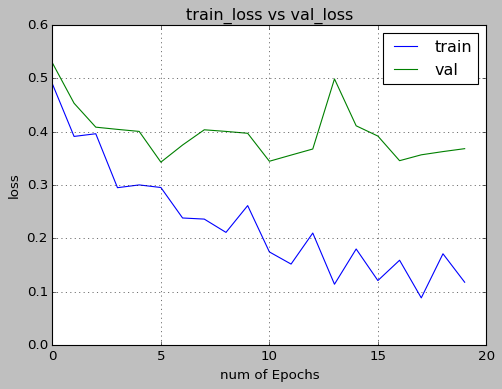

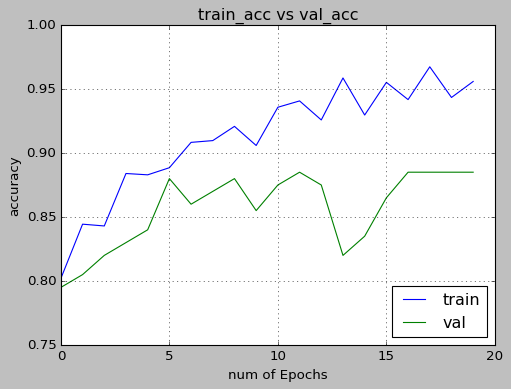

In [0]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist2.history['loss']
val_loss=hist2.history['val_loss']
train_acc=hist2.history['acc']
val_acc=hist2.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

# Saving File of Model

In [0]:
custom_vgg_model2.summary()

In [0]:
print(data_path)

/content/drive/ContentBlocker/Dataset


In [0]:
weights_path = data_path + "/model_weights.h5"

In [0]:
from keras.models import load_model 
#custom_vgg_model2.save('my_model.h5') # creates a HDF5 file 'my_model.h5'
custom_vgg_model2.save_weights(weights_path)
print("Saved model to drive")

Saved model to drive


In [0]:
files.download(weights_path)  # from colab to browser download

# Loading Model File

In [0]:
weights_path = data_path + "/model_weights.h5"

In [0]:
custom_vgg_model2.load_weights(weights_path)

# Classify New Images

In [0]:
image_path = data_path + '/Train/Non_abusive/10. main-qimg-6981856f5129bb2a111a8e0ac56a4e92-c.jpg'
blur = 0

In [0]:
image_path = os.getcwd() + '/drive/ContentBlocker/Blur/1.jpg'
blur = 0

In [29]:
import os
from IPython.display import Image, display

from keras.preprocessing.image import load_img
# load an image from file
image = load_img((image_path), target_size=(224, 224))

from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

# predict the probability across all output classes
yhat = custom_vgg_model2.predict(image)

print(yhat[0])

if (yhat[0][0]<=0.5):
  print('Non-abusive')
  blur=1



[0. 0. 1.]
Non-abusive


In [0]:
# 1st category: abusive
# 2nd category: close to abusive
# 3rd category: non-abusive

# Bluring images

In [25]:
import cv2
import os
PATH = os.getcwd()
print(PATH)
img_data_list=[]
# Define data path
folder = PATH + '/drive/ContentBlocker/Blur/1.jpg'
images = []


/content


In [30]:
import cv2
import os
#for filename in os.listdir(folder):
img = cv2.imread(image_path)
if(blur==1):
  gausBlur = cv2.GaussianBlur(img, (45,45),0) 
  for i in range(2):
    gausBlur = cv2.GaussianBlur(gausBlur, (45,45),0)  
  cv2.imwrite('blured.jpg',gausBlur)
  print("image saved")

image saved


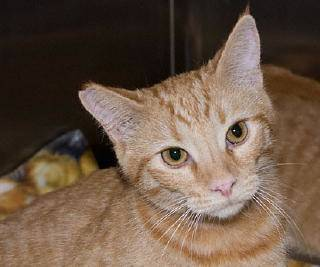

In [31]:
from IPython.display import Image, display
display(Image(image_path))

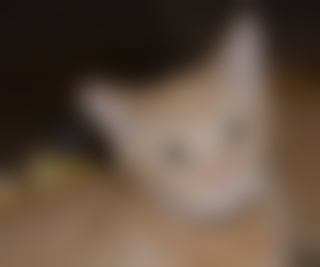

In [32]:
display(Image('blured.jpg'))

In [0]:
!ls

datalab  drive	imagenet_utils.py  __pycache__	vgg16.py
